In [1]:
import sys , os
sys.path.append('../')

import dnn.bitwise_ss as bitwise_ss
import dnn.binary_layers as binary_layers
import dnn.bitwise_mlp as bitwise_mlp
import datasets.binary_data as binary_data
import loss_and_metrics.bss_eval as bss_eval
import torch
import torch.nn.functional as F
import numpy as np
import IPython.display as ipd
import soundfile as sf
import seaborn as sns
import pandas as pd
import mir_eval
import matplotlib
import matplotlib.pyplot as plt
import pickle as pkl

# Inverse Blues colormap
cdict = {
    'red':   ((0.0,  1.0, 1.0), (1.0,  0.0, 0.0)),
    'green': ((0.0,  1.0, 1.0), (1.0,  .15, .15)),
    'blue':  ((0.0,  1.0, 1.0), (1.0,  0.4, 0.4)),
    'alpha': ((0.0,  0.0, 0.0), (1.0,  1.0, 1.0))}
plt.register_cmap(name='InvBlueA', data=cdict)

# Customize my figure style
plt.rc('figure', figsize=(8,4), dpi=96, facecolor='#FFFFFF00', autolayout=False)
plt.rc('lines', linewidth=1)
plt.rc('axes', axisbelow=True, titlesize=10, titleweight=500, 
   labelsize=9, labelweight=400, linewidth=0.5, facecolor='#FFFFFF00')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes.spines', right=False, top=False)
plt.rc('grid', linestyle='-', linewidth=0.5)

# Get a decent figure font
matplotlib.font_manager._rebuild()
plt.rc('font', family='Avenir Next LT Pro', weight=400, size=9)

# Light colors
plt.rc('axes', edgecolor='#404040')
plt.rc('grid', color='#DDDDDD')
plt.rc('xtick', color='#222222')
plt.rc('ytick', color='#222222')
plt.rc('text', color='#222222')
plt.rc('image', cmap='InvBlueA')
plt.rc('legend', facecolor='#FFFFFF55', framealpha=0.5)

%load_ext autoreload
%autoreload 2

# Binary Neural Network

In [2]:
def get_audio_output(model, binary_sample, raw_sample):
    mix = raw_sample['mixture']
    target = raw_sample['target']
    val_mag, val_phase = binary_data.stft(mix)
    bmag = torch.FloatTensor(binary_sample['bmag']).unsqueeze(0)
    model_in = bitwise_ss.flatten(bmag)
    premask = model(model_in)
    premask = bitwise_ss.unflatten(premask, bmag.size(0), bmag.size(2))
    mask = binary_data.make_binary_mask(premask).squeeze(0)
    estimate = binary_data.istft(val_mag * mask.numpy(), val_phase)
    ipd.display(ipd.Audio(mix, rate=16000))
    ipd.display(ipd.Audio(estimate, rate=16000))
    ipd.display(ipd.Audio(target, rate=16000))

In [3]:
valset = binary_data.DatasetFromDirectory('/media/data/binary_audio/val', template='binary_data*.npz')
raw_valset = binary_data.DatasetFromDirectory('/media/data/binary_audio/val', template='raw_data*.npz')
testset = binary_data.DatasetFromDirectory('/media/data/binary_audio/test', template='binary_data*.npz')
raw_testset = binary_data.DatasetFromDirectory('/media/data/binary_audio/test', template='raw_data*.npz')
print('Number of Binary Validation Examples: ', len(valset))
print('Number of Binary Test Examples: ', len(testset))

Number of Binary Validation Examples:  400
Number of Binary Test Examples:  400


## Bitwise Neural Network Evaluation

In [5]:
# Evaluate real source separation network
directory = '../models/'
models = ['net_relu.model']
weight_activations = ['relu']
metrics = []

for weight_activation, model in zip(weight_activations, models):
    mlp = bitwise_mlp.BitwiseMLP(2052, 513, fc_sizes=[2048, 2048], activation='relu', 
                                 weight_activation=weight_activation)
    mlp.load_state_dict(torch.load(directory + model))
    mlp.eval()
    loss, met = bitwise_ss.evaluate(mlp, testset, raw_testset, loss=F.binary_cross_entropy_with_logits)
    sdr, sir, sar = met.mean()
    print(model)
    print('Mean SDR: ', sdr)
    print('Mean SIR: ', sir)
    print('Mean SAR: ', sar)

TypeError: __init__() got an unexpected keyword argument 'weight_activation'

In [6]:
directory = '../models/'
models = ['net_nocw_cg_tanh.model', 'net_cw_cg_tanh.model']
metrics = []
for model in models:
    # Evaluate real source separation network
    mlp = bitwise_mlp.BitwiseMLP(2052, 513, fc_sizes=[2048, 2048], 
                                 in_bin=binary_layers.clipped_ste, 
                                 weight_bin=binary_layers.clipped_ste, 
                                 activation=binary_layers.identity)
    mlp.load_state_dict(torch.load(directory + model))
    mlp.eval()
    loss, met = bitwise_ss.evaluate(mlp, valset, raw_valset, loss=F.binary_cross_entropy_with_logits)
    sdr, sir, sar = met.mean()
    print(model)
    print('Mean SDR: ', sdr)
    print('Mean SIR: ', sir)
    print('Mean SAR: ', sar)
    metrics.append(met)

KeyboardInterrupt: 

In [10]:
get_audio_output(mlp, testset[0], raw_testset[0])

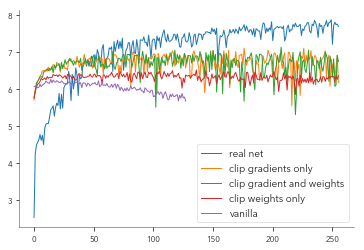

In [4]:
directory = '../results/'
data_files = ['net_tanh.pkl', 'net_nocw_cg_tanh.pkl', 'net_cw_cg_tanh.pkl', 'net_cw_nocg_tanh.pkl', 'net_nocw_nocg_tanh.pkl']
names = ['real net', 'clip gradients only', 'clip gradient and weights', 'clip weights only', 'vanilla']
curves = []

for name, file in zip(names, data_files):
    with open(directory + file, 'rb') as f:
        data = pkl.load(f)
    curve, = plt.plot(data.sdrs, label=name)
    curves.append(curve)
plt.legend(curves, names)

In [27]:
sdrs = np.stack([metrics[i].sdrs for i in range(len(metrics))], axis=1)
sirs = np.stack([metrics[i].sirs for i in range(len(metrics))], axis=1)
sars = np.stack([metrics[i].sars for i in range(len(metrics))], axis=1)
names = ['noinit', 'identity', 'tanh', 'stetanh']

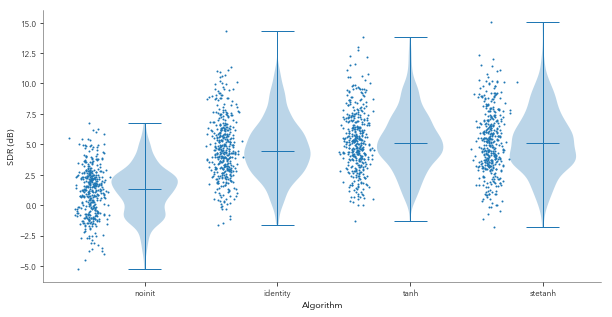

In [28]:
plt.figure(figsize=(10, 5))
plt.violinplot(sdrs, bw_method=.25, showmedians=True)
plt.xticks(np.arange(1, len(names)+1), names)
for i in range(sdrs.shape[1]):
    plt.plot(i+np.random.randn(400)/20+.6, sdrs[:,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SDR (dB)')
plt.savefig('sdrs.png')

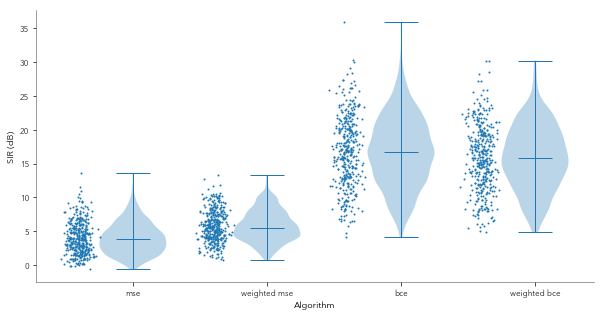

In [39]:
plt.figure(figsize=(10, 5))
plt.violinplot(sirs, bw_method=.25, showmedians=True)
plt.xticks(np.arange(1, len(labels)+1), labels)
for i in range(sdrs.shape[1]):
    plt.plot(i+np.random.randn(400)/20+.6, sirs[:,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SIR (dB)')
plt.savefig('sirs.png')

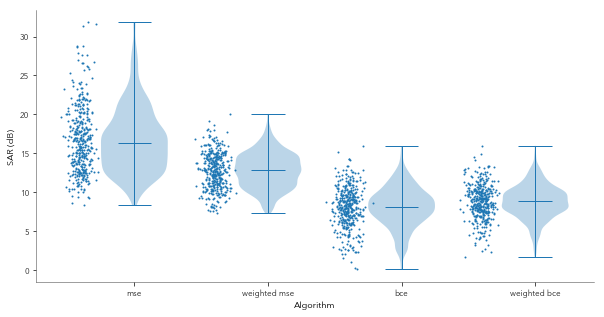

In [40]:
plt.figure(figsize=(10, 5))
plt.violinplot(sars, bw_method=.25, showmedians=True)
plt.xticks(np.arange(1, len(labels)+1), labels)
for i in range(sdrs.shape[1]):
    plt.plot(i+np.random.randn(400)/20+.6, sars[:,i], 'C0.', ms=2)
plt.xlabel('Algorithm')
plt.ylabel('SAR (dB)')
plt.savefig('sars.png')